In [14]:
import numpy as np
from scipy.optimize import minimize
import networkx as nx
import matplotlib.pyplot as plt
%matplotlib inline
import random

In [15]:
def sum_of_powers(G, n):
    """
    Compute the sum of powers of a matrix G up to the n-th power: G + G^2 + ... + G^n.
    
    Parameters:
    - G: numpy array, the matrix G.
    - n: int, the highest power to include in the sum.
    
    Returns:
    - sum_powers: numpy array, the sum of powers of G from 1 to n.
    """
    sum_powers = np.zeros_like(G)  # Initialize the sum as a zero matrix of the same shape as G
    current_power = np.copy(G)  # The current power of G, starting with G itself
    
    for i in range(1, n + 1):
        sum_powers += current_power  # Add the current power to the sum
        current_power = np.dot(current_power, G)  # Compute the next power of G
        
    return sum_powers

In [51]:
def generate_matrix_with_infinity_norm_less_than_one(n):
    # Generate an n x n matrix with random values between -0.5 and 0.5
    A = np.random.rand(n, n) - 0.5
    
    # Scale each row so that the sum of the absolute values is less than 1
    for i in range(n):
        row_sum = np.sum(np.abs(A[i, :]))
        scaling_factor = np.random.uniform(low=0.0, high=1.0) / row_sum
        A[i, :] *= scaling_factor

    np.fill_diagonal(A, 0)
        
    return A

def generate_matrix_with_2_norm_less_than_one(n):
    # Generate an n x n matrix with random values
    A = np.random.randn(n, n)
    
    # Perform SVD
    U, s, Vh = np.linalg.svd(A)
    
    # Scale singular values to ensure all are less than 1
    s_scaled = np.random.uniform(low=0.0, high=1.0, size=s.shape)
    
    # Reconstruct the matrix with scaled singular values
    A_scaled = np.dot(U, np.dot(np.diag(s_scaled), Vh))

    np.fill_diagonal(A_scaled, 0)
    
    return A_scaled

# Agent Utilitiy

In [84]:
def agent_utility(q, x, G, i):
    """
    Calculate the quadratic utility for agent i.
    
    Parameters:
    - q (numpy array): The linear coefficients for each agent.
    - x (numpy array): The choices or quantities selected by each agent.
    - g (numpy matrix or 2D array): The interaction coefficients between agents.
    - i (int): The index of the agent for whom to calculate the utility.
    
    Returns:
    - float: The calculated utility for agent i.
    """
    # Linear term for agent i
    linear_term = q[i] * x[i]
    
    # Quadratic term for agent i
    quadratic_term = -0.5 * x[i]**2
    
    # Interaction term for agent i with all other agents j
    interaction_term = -np.sum([G[i, j] * x[i] * x[j] for j in range(len(x))])
    
    # Total utility for agent i
    utility_i = linear_term + quadratic_term + interaction_term
    
    return utility_i


# Example usage
q = np.array([1, 2, 3])  # Linear coefficients for agents
# x = np.array([0.5, 1.5, 2.5])  # Choices of agents
x = np.array([random.uniform(0, 3) for i in range(3)])
print(x)
g = np.array([[0, 0.1, 0.2],  # Interaction coefficients between agents
              [0.1, 0, 0.3],
              [0.2, 0.3, 0]])
# i = 0  # Agent index for whom we're calculating the utility

for i in range(3):
    utility_i = agent_utility(q, x, g, i)
    print(f"The calculated utility for agent {i} is: {utility_i}")

[1.1089808  0.4529288  0.39344494]
The calculated utility for agent 0 is: 0.35656808278927754
The calculated utility for agent 1 is: 0.6995956569769572
The calculated utility for agent 2 is: 0.962210012651739


# Socially Optimal Solution

In [104]:
def total_utility(x, q, g):
    """
    Calculate the total utility for all agents by summing individual utilities.
    """
    return sum(agent_utility(q, x, g, i) for i in range(len(q)))


def find_social_optimum(q, g, bounds):
    """
    Find the socially optimal solution that maximizes the total utility.
    """
    num_agents = len(q)
    x0 = np.ones(num_agents)/2  # Initial guess for the optimization
    
    # Minimize the negative of the total utility to find the maximum total utility
    objective = lambda x: -total_utility(x, q, g)
    opt_result = minimize(objective, x0, bounds=bounds)

    return opt_result

# n = 10
# q = np.random.rand(n)  # Random linear coefficients for agents

# flag = True
# while flag:
#     g = generate_matrix_with_infinity_norm_less_than_one(n)  # Random interaction coefficients between agents
#     norm_g = np.linalg.norm(g, ord=np.inf)
#     # g = generate_matrix_with_2_norm_less_than_one(n)  # Random interaction coefficients between agents
#     # norm_g = np.linalg.norm(g, ord=2)
#     if norm_g < 1:
#         flag = False

# bounds = [(0, None)] * n  # Assume non-negative choices

# opt_result = find_social_optimum(q, g, bounds)
# print(f"Socially optimal solution: {opt_result.x}")
# print(f"Maximum total utility: {-opt_result.fun}")
# # totla utility for x
# # x = np.array([random.uniform(0, 3) for i in range(n)])
# # print(f"Total utility for x = {x}: {total_utility(x, q, g)}")


# Individual Maximization

In [226]:
def optimize_agent_i(q, g, x, i, bounds_i):
    """
    Optimize the choice for agent i, given current choices of other agents.
    """
    def objective_i(x_i):
        x_new = np.copy(x)
        x_new[i] = x_i
        return -agent_utility(q, x_new, g, i)

    result = minimize(objective_i, x[i], bounds=[bounds_i])
    if result.x < 0:
        return 0
    else:
        return result.x


def maximize_individual_utilities_iteratively(q, g, initial_x, bounds, tol=1e-2, max_iter=100):
    """
    Iteratively maximize each agent's utility until convergence.
    """
    x = np.copy(initial_x)
    for iteration in range(max_iter):
        x_new = np.copy(x)
        for i in range(len(q)):
            x_new[i] = optimize_agent_i(q, g, x, i, bounds[i])

        # Check for convergence
        if np.linalg.norm(x_new - x) < tol:
            # print(f"Convergence achieved after {iteration + 1} iterations.")
            break
        x = x_new
    # else:
        # print("Max iterations reached without convergence.")

    return x

# Function for creating different types of networks

1.8761311785206887
0.9624891867619528

Socially optimal solution: [       0.                0.          1477995.03242166  8648799.43050005
 20417455.49406041 26427533.38445721 21564965.80037745 12129225.81912022
  5636619.27584569        0.        ]
Maximum total utility: 77902136388392.06

Efforts at hop 10: [0.         0.         0.         0.42649199 0.93519565 0.74186433
 1.2826938  1.81101312 0.33915596 0.        ]
Total utility at hop 10: 3.2646366355469327


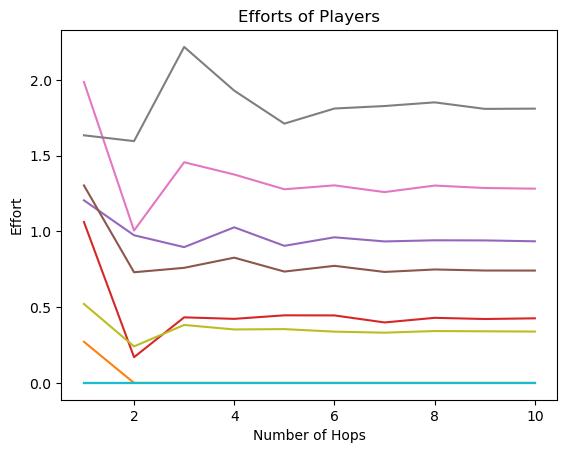

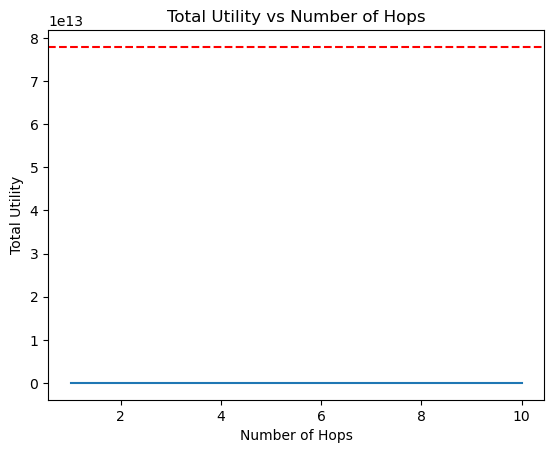

In [225]:
n = 10
q = np.random.rand(n)  # Random linear coefficients for agents

flag = True
while flag:
    # g = generate_matrix_with_infinity_norm_less_than_one(n)  # Random interaction coefficients between agents
    g = generate_matrix_with_2_norm_less_than_one(n)  # Random interaction coefficients between agents
    norm_inf_g = np.linalg.norm(g, ord=np.inf)
    norm_2_g = np.linalg.norm(g, ord=2)
    if (norm_2_g < 1): # and norm_inf_g < 1
        flag = False

# print the norm of g
print(np.linalg.norm(g, ord=np.inf))
print(np.linalg.norm(g, ord=2))

bounds = [(0, None)] * n  # Assume non-negative choices

opt_result = find_social_optimum(q, g, bounds)
print(f"\nSocially optimal solution: {opt_result.x}")
print(f"Maximum total utility: {-opt_result.fun}\n")

soc_opt_result = find_social_optimum(q, g, bounds)

max_hops = 10

x_init = soc_opt_result.x
# x_init = np.ones(n)

x_nash_list = []
for hops in range(1, max_hops + 1):
    x_nash = maximize_individual_utilities_iteratively(q, sum_of_powers(g, hops), x_init, bounds)
    x_nash_list.append(x_nash)
    # print total utility

print(f"Efforts at hop {max_hops}: {x_nash_list[-1]}")
print(f"Total utility at hop {max_hops}: {total_utility(x_nash_list[-1], q, sum_of_powers(g, max_hops))}")

plt.figure()
for i in range(n):
    plt.plot(range(1, max_hops + 1), [x_nash[i] for x_nash in x_nash_list], label=f'Player {i}')
    # plt.plot(range(1, max_hops + 1), [x_opt[i]] * max_hops, label=f'Player {i} (optimal)', linestyle='--')
plt.xlabel("Number of Hops")
plt.ylabel("Effort")
plt.title(f"Efforts of Players")
plt.show()

# plot the total utility vs number of hops
utility_list1 = [total_utility(x_nash, q, sum_of_powers(g, i)) for i, x_nash in enumerate(x_nash_list)]
plt.plot(range(1, max_hops + 1), utility_list1)
plt.axhline(y=-soc_opt_result.fun, color='r', linestyle='--', label='Social Optimum')
plt.xlabel("Number of Hops")
plt.ylabel("Total Utility")
plt.title("Total Utility vs Number of Hops")
plt.show()

In [81]:
n = 20
max_hops = 20
q = np.random.rand(n)  # Random linear coefficients for agents
bounds = [(0, None)] * n  # Assume non-negative choices
x_init = np.ones(n)

flag = True
while flag:
    # g = generate_matrix_with_infinity_norm_less_than_one(n)  # Random interaction coefficients between agents
    # norm_g = np.linalg.norm(g, ord=np.inf)
    g = generate_matrix_with_2_norm_less_than_one(n)  # Random interaction coefficients between agents
    norm_g = np.linalg.norm(g, ord=2)
    if norm_g < 1:
        flag = False
G = g

Convergence achieved after 12 iterations.
Convergence achieved after 43 iterations.


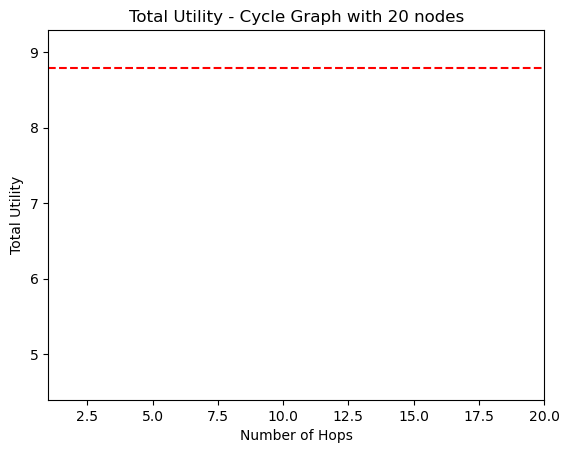

In [82]:
soc_opt_result = find_social_optimum(q, G, bounds)

x_nash_list1 = []
for hops in range(1, max_hops + 1):
    x_nash = maximize_individual_utilities_iteratively(q, sum_of_powers(G, hops), x_init, bounds)
    x_nash_list1.append(x_nash)

# plot the total utility as a function of the number of hops
plt.figure()
plt.plot(range(1, max_hops + 1), [total_utility(x_nash, q, sum_of_powers(G, i)) for i, x_nash in enumerate(x_nash_list1, 1)])
# plot socially optimal utility
plt.axhline(-soc_opt_result.fun, color='r', linestyle='--', label='Socially Optimal')
plt.xlim(1, max_hops)
plt.ylim(-soc_opt_result.fun/2, 0.5-soc_opt_result.fun)
plt.xlabel("Number of Hops")
plt.ylabel("Total Utility")
plt.title(f"Total Utility - Cycle Graph with {n} nodes")
plt.show()